Hiányzó adatok:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Year         0
dtype: int64
Éves statisztikák:
       Átlagos nap végi ár  Legkisebb nap végi ár  Legnagyobb nap végi ár  \
Year                                                                       
1999             0.048681               0.034115                0.097786   
2000             0.219471               0.077214                0.360286   
2001             0.329539               0.124740                0.578167   
2002             0.240369               0.061417                0.597583   
2003             0.147509               0.080833                0.221417   
2004             0.161648               0.078583                0.227000   
2005             0.237846               0.171500                0.317667   
2006             0.452399               0.294500                0.645000   
2007             0.693114               0.472500                0.988500   
2008     

C:\Users\Peti\AppData\Local\Temp\ipykernel_31328\899023354.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True) #ures adatok eseten feltoltes


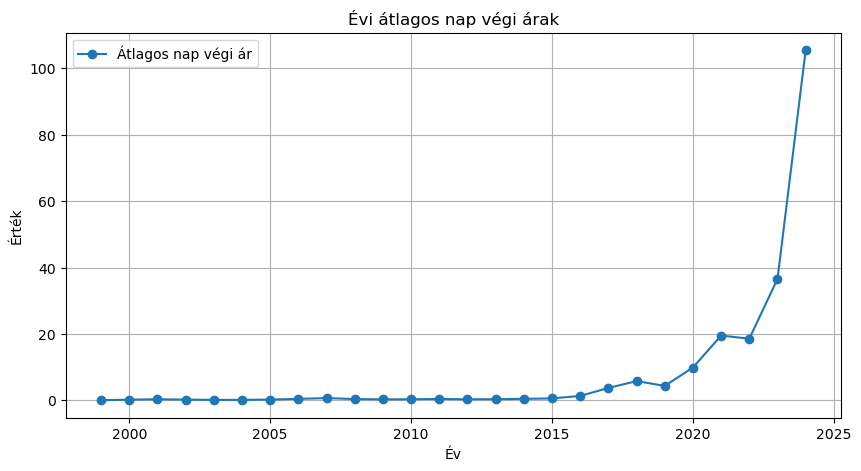

Epoch 1/20
162/162 [==============================] - 4s 16ms/step - loss: 1.5240e-05 - val_loss: 0.0193
Epoch 2/20
162/162 [==============================] - 2s 14ms/step - loss: 3.9841e-06 - val_loss: 0.0177
Epoch 3/20
162/162 [==============================] - 2s 14ms/step - loss: 5.1651e-06 - val_loss: 0.0120
Epoch 4/20
162/162 [==============================] - 2s 13ms/step - loss: 3.7128e-06 - val_loss: 0.0124
Epoch 5/20
162/162 [==============================] - 2s 13ms/step - loss: 4.1002e-06 - val_loss: 0.0118
Epoch 6/20
162/162 [==============================] - 2s 13ms/step - loss: 3.9733e-06 - val_loss: 0.0154
Epoch 7/20
162/162 [==============================] - 2s 14ms/step - loss: 4.4680e-06 - val_loss: 0.0097
Epoch 8/20
162/162 [==============================] - 2s 14ms/step - loss: 3.7225e-06 - val_loss: 0.0115
Epoch 9/20
162/162 [==============================] - 2s 14ms/step - loss: 4.1784e-06 - val_loss: 0.0089
Epoch 10/20
162/162 [==============================] - 

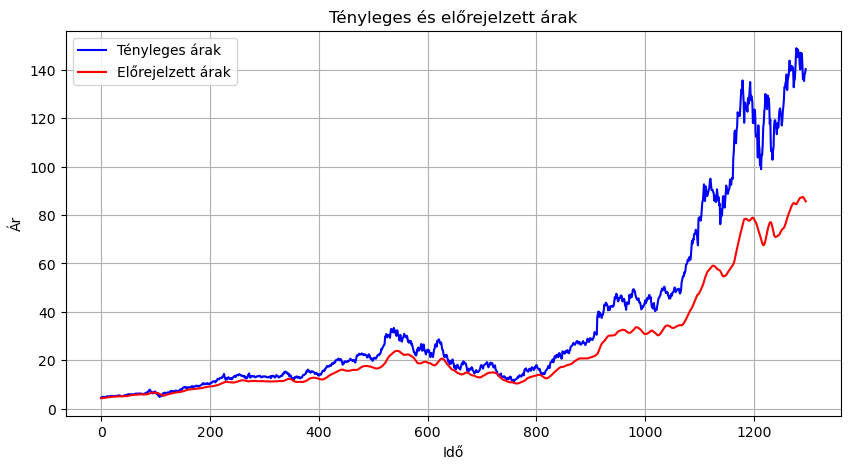

In [11]:
#szukseges library-k importalasa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

data = pd.read_csv('NVDA_1999-01-01_2024-12-04.csv') #tablazat betoltese

data['Date'] = pd.to_datetime(data['Date']) #'Date' oszlop konvertalasa 'datetime'-ba 
data.set_index('Date', inplace=True)

data['Year'] = data.index.year

data_missing = data.isnull().sum() #van-e hianyzo adat
print("Hiányzó adatok:\n", data_missing)
data.fillna(method='ffill', inplace=True) #ures adatok eseten feltoltes

#eves hianyossagok osszeszamolasa
yearly_stats = data.groupby('Year').agg({
    'Close': ['mean', 'min', 'max'],
    'Volume': 'sum'
})
yearly_stats.columns = ['Átlagos nap végi ár', 'Legkisebb nap végi ár', 'Legnagyobb nap végi ár', 'Összes mozgás']
print("Éves statisztikák:\n", yearly_stats)

#éves nap végi árak átlagos valtozasanak kiertekelese
yearly_stats['yChange'] = yearly_stats['Átlagos nap végi ár'].pct_change() * 100
print("Nap végi árak éves átlagos változása:\n", yearly_stats['yChange'])

#legnagyobb eltereseket produkalo ev megtalalasa
greatest_increase = yearly_stats['yChange'].idxmax()
greatest_decrease = yearly_stats['yChange'].idxmin()
print(f"Év a legnagyobb nap végi Stock érték növekedéssel: {greatest_increase}")
print(f"Év a legkisebb nap végi Stock érték növekedéssel: {greatest_decrease}")

#eves atlagok megjelenitese grafikonban
plt.figure(figsize=(10, 5))
plt.plot(yearly_stats.index, yearly_stats['Átlagos nap végi ár'], marker='o', label='Átlagos nap végi ár')
plt.title('Évi átlagos nap végi árak')
plt.xlabel('Év')
plt.ylabel('Érték')
plt.legend()
plt.grid()
plt.show()

#LSTM (long short term memory) model megalkotasa
scaler = MinMaxScaler()
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

sequence_length = 30  #utolso 30 nap figyelembe vetele az elorejelzeshez
scaled_close = data['Scaled_Close'].values
x, y = create_sequences(scaled_close, sequence_length)

#adatok szetvalasztasa tesztelo es tanulo matrixba
split = int(len(x) * 0.8)
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

#adatok feldolgozasa/atdolgozasa
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#LSTM model megalkotasa
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

#tanitas
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=1)

#kiertekeles
loss = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")

#elorejelzesek megcsinalasa
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

#tenyleges vs elorejelzett adatok grafikonja
plt.figure(figsize=(10, 5))
plt.title('Tényleges és előrejelzett árak')
plt.plot(y_test_actual, label='Tényleges árak', color='blue')
plt.plot(predictions, label='Előrejelzett árak', color='red')
plt.xlabel('Idő')
plt.ylabel('Ár')
plt.legend()
plt.grid()
plt.show()


2.10.0
